In [1]:
import os
import json
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.utils import resample
from uuid import uuid4
from tqdm import tqdm
from typing import Dict, List, Optional
from datetime import datetime

# 1. Dataset builder

In [2]:
# Define paths
METADATA_SERENGETI_PATH = "/data/luiz/dataset/serengeti/SnapshotSerengeti_S1-11_v2.1.json"
DATA_SERENGETI_PATH = "/data/luiz/dataset/serengeti_images/"
DATA_SERENGETI_SSD_PATH = "/ssd/luiz/dataset/serengeti_images/"
SPECIES_CSV_SERENGETI_PATH = "/data/luiz/dataset/partitions/species-classifier/serengeti"
ANIMAL_CSV_SERENGETI_PATH = "/data/luiz/dataset/partitions/species-classifier/serengeti"

# METADATA_SERENGETI_PATH = "C:\\Users\\fabio\\Documents\\Workspace\\my-repos\\WildMatch\\data\\serengeti\\metadata.json"
# DATA_SERENGETI_PATH = "C:\\Users\\fabio\\Documents\\Workspace\\my-repos\\WildMatch\\"

Utils functions

In [ ]:
def load_json(json_file_path):
    print(f"Loading JSON file from {json_file_path}")
    with open(json_file_path, 'r') as f:
        return json.load(f)
    
def merge_annotations_and_images(data, image_base_path):
    """
    Merge annotations with images data and filter out images that don't exist.
    
    Args:
        data: Dictionary containing 'annotations' and 'images' lists
        image_base_path: Base path where images are stored
    
    Returns:
        List of dictionaries with merged data (only for existing images)
    """
    # Create a mapping from image_id to image metadata
    images_dict = {img['id']: img for img in data['images']}
    
    # Create a mapping from image_id to annotation
    annotations_dict = {ann['image_id']: ann for ann in data['annotations']}
    
    merged_data = []
    missing_images = []
    
    print(f"Total images in metadata: {len(data['images'])}")
    print(f"Total annotations: {len(data['annotations'])}")
    print(f"\nChecking which images exist on disk...")
    
    for img in tqdm(data['images']):
        image_id = img['id']
        file_name = img['file_name']
        
        # Construct full image path
        image_path = os.path.join(image_base_path, file_name)
        
        # Check if image exists
        if os.path.exists(image_path):
            # Get corresponding annotation if it exists
            annotation = annotations_dict.get(image_id, None)
            
            # Merge image and annotation data
            merged_item = {
                **img,  # Include all image metadata
                'full_path': image_path,
            }
            
            # Add annotation data if available
            if annotation:
                merged_item.update({
                    'annotation_id': annotation['id'],
                    'category_id': annotation['category_id'],
                    'seq_id': annotation['seq_id'],
                    'season': annotation['season'],
                    'subject_id': annotation['subject_id'],
                    'count': annotation['count'],
                    'standing': annotation['standing'],
                    'resting': annotation['resting'],
                    'moving': annotation['moving'],
                    'interacting': annotation['interacting'],
                    'young_present': annotation['young_present'],
                })
            else:
                merged_item['annotation_id'] = None
                merged_item['category_id'] = None
            
            merged_data.append(merged_item)
        else:
            missing_images.append({
                'image_id': image_id,
                'file_name': file_name,
                'expected_path': image_path
            })
    
    print(f"\n✓ Found {len(merged_data)} existing images")
    print(f"✗ Missing {len(missing_images)} images")
    
    return merged_data, missing_images

# Function to balance the dataset
def balance_dataset(df, category_col, min_samples=100):
    # Count samples per class
    class_counts = df[category_col].value_counts()
    
    # Target size = smallest class count
    min_size = class_counts.min()
    if min_size > min_samples:
        min_size = min_samples

    balanced_list = []

    # Downsample each class to min_size
    for class_value in class_counts.index:
        df_class = df[df[category_col] == class_value]
        df_downsampled = resample(
            df_class,
            replace=False,
            n_samples=min_size,
            random_state=123
        )
        balanced_list.append(df_downsampled)
    
    # Combine all classes
    df_balanced = pd.concat(balanced_list).reset_index(drop=True)
    
    return df_balanced

# Function to copy images to a specified directory
def copy_images_to_directory(df, source_col, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    paths = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Copying images"):
        src = row[source_col]
        paths.append(os.path.join(dest_dir, os.path.basename(src)))
        if os.path.exists(src):
            shutil.copy(src, dest_dir)

    df[source_col] = paths
    return df


In [4]:
CATEGORIES_TO_REMOVE = [0, 1, 23]

SPECIES_TO_INCLUDE = [
  "elephant",
  "ostrich",
  "zebra",
  "cheetah",
  "hippopotamus",
  "baboon",
  "buffalo",
  "giraffe",
  "warthog",
  "guineafowl",
  "hyenaspotted",
  "impala"
]

CSV_PATH = '../data/serengeti/dataset.csv'

In [ ]:
data = load_json(METADATA_SERENGETI_PATH)

# Merge data and filter existing images
merged_data, missing_images = merge_annotations_and_images(data, DATA_SERENGETI_PATH)

# Convert to DataFrame for easier analysis
df_original = pd.DataFrame(merged_data)

# Filter out unwanted categories
df = df_original[~df_original['category_id'].isin(CATEGORIES_TO_REMOVE)]

# Create a mapping from category_id to species name
category_map = {cat['id']: cat['name'] for cat in data['categories']}

# Add species_name column
df['species_name'] = df['category_id'].map(category_map)

print("Species distribution:")
print(df['species_name'].value_counts())
print(f"\nTotal unique species: {df['species_name'].nunique()}")
print(f"Samples with unknown category: {df['species_name'].isna().sum()}")

df = df[df['species_name'].isin(SPECIES_TO_INCLUDE)]
df['species_name'].value_counts()

Loading JSON file from /data/luiz/dataset/serengeti/SnapshotSerengeti_S1-11_v2.1.json
Total images in metadata: 7178440
Total annotations: 7261545

Checking which images exist on disk...


100%|██████████| 7178440/7178440 [02:13<00:00, 53875.56it/s] 



✓ Found 3197506 existing images
✗ Missing 3980934 images


In [ ]:
# Balance the dataset
df_balanced = balance_dataset(df, 'category_id')

# Copy images to the specified directory
df_balanced = copy_images_to_directory(df_balanced, 'full_path', '../data/serengeti/images')

# Save the balanced dataset to CSV
df_balanced.to_csv(CSV_PATH, index=False)

Copying images:   0%|          | 0/1200 [00:00<?, ?it/s]

Copying images: 100%|██████████| 1200/1200 [00:00<00:00, 3362.73it/s]


In [7]:
df_balanced =  pd.read_csv(CSV_PATH)
df_balanced

,id,file_name,frame_num,seq_id,width,height,corrupt,location,seq_num_frames,datetime,...,category_id,season,subject_id,count,standing,resting,moving,interacting,young_present,species_name
0,S4/T12/T12_R2/S4_T12_R2_IMAG1234,S4/T12/T12_R2/S4_T12_R2_IMAG1234.JPG,1,SER_S4#T12#2#472,2048,1536,False,T12,3,2012-04-19 08:45:38,...,5,S4,ASG000do06,3,0.25,0.00,0.08,0.0,0.0,zebra
1,S6/B07/B07_R2/S6_B07_R2_IMAG0070,S6/B07/B07_R2/S6_B07_R2_IMAG0070.JPG,1,SER_S6#B07#2#27,2048,1536,False,B07,3,2013-03-03 09:29:52,...,5,S6,ASG000y31s,1,0.94,0.00,0.06,0.0,0.0,zebra
2,S4/C13/C13_R1/S4_C13_R1_IMAG1852,S4/C13/C13_R1/S4_C13_R1_IMAG1852.JPG,3,SER_S4#C13#1#628,2048,1536,False,C13,3,2012-02-09 11:39:53,...,5,S4,ASG000ck0k,7,0.54,0.00,0.69,0.0,0.0,zebra
3,S2/C04/C04_R3/S2_C04_R3_IMAG1412,S2/C04/C04_R3/S2_C04_R3_IMAG1412.JPG,2,SER_S2#C04#3#505,2048,1536,False,C04,3,2011-05-17 07:42:31,...,5,S2,ASG0003n1a,2,0.15,0.00,0.15,0.0,0.0,zebra
4,S2/G01/G01_R1/S2_G01_R1_PICT0873,S2/G01/G01_R1/S2_G01_R1_PICT0873.JPG,2,SER_S2#G01#1#292,2048,1536,False,G01,3,2011-03-12 18:15:27,...,5,S2,ASG000516i,1,0.15,0.00,0.23,0.0,0.0,zebra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,S5/H07/H07_R3/S5_H07_R3_IMAG0016,S5/H07/H07_R3/S5_H07_R3_IMAG0016.JPG,2,SER_S5#H07#3#8,2048,1536,False,H07,3,2012-10-16 07:38:13,...,20,S5,ASG000pv56,1,0.00,0.00,1.00,0.0,0.0,ostrich
1196,S5/O07/O07_R2/S5_O07_R2_IMAG0509,S5/O07/O07_R2/S5_O07_R2_IMAG0509.JPG,1,SER_S5#O07#2#175,2048,1536,False,O07,3,2012-09-26 12:40:22,...,20,S5,ASG000s8on,1,0.00,0.00,0.25,0.5,0.0,ostrich
1197,S3/T09/T09_R11/S3_T09_R11_IMAG0099,S3/T09/T09_R11/S3_T09_R11_IMAG0099.JPG,3,SER_S3#T09#11#33,2048,1536,False,T09,3,2011-09-29 14:41:52,...,20,S3,ASG0008tu3,1,0.09,0.00,0.91,0.0,0.0,ostrich
1198,S6/U13/U13_R1/S6_U13_R1_IMAG2906,S6/U13/U13_R1/S6_U13_R1_IMAG2906.JPG,2,SER_S6#U13#1#1313,2560,1920,False,U13,3,2013-01-19 10:10:24,...,20,S6,ASG0011sxj,2,0.43,0.14,0.00,0.0,0.0,ostrich


## 1.1 Analyze sequence-level data (needed for Section 11 of paper)

In [ ]:
# Group by sequence to see how many frames per sequence
sequence_stats = df_balanced.groupby('seq_id').agg({
    'id': 'count',  # Number of frames
    'species_name': 'first',  # Species (should be same across sequence)
    'datetime': ['min', 'max']  # Time range
}).round(2)

sequence_stats.columns = ['num_frames', 'species', 'start_time', 'end_time']
sequence_stats = sequence_stats.reset_index()

print("Sequence-level statistics:")
print(f"Total sequences: {len(sequence_stats)}")
print(f"\nFrames per sequence distribution:")
print(sequence_stats['num_frames'].describe())
print(f"\nSequences with multiple frames: {(sequence_stats['num_frames'] > 1).sum()}")

Sequence-level statistics:
Total sequences: 1189

Frames per sequence distribution:
count    1189.000000
mean        1.009251
std         0.095779
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: num_frames, dtype: float64

Sequences with multiple frames: 11


In [9]:
sequence_stats

,seq_id,num_frames,species,start_time,end_time
0,SER_S1#B05#3#8,1,hyenaspotted,2010-08-28 19:49:30,2010-08-28 19:49:30
1,SER_S1#B07#1#17,1,hyenaspotted,2010-09-11 00:49:48,2010-09-11 00:49:48
2,SER_S1#B07#1#183,1,ostrich,2010-09-26 14:46:34,2010-09-26 14:46:34
3,SER_S1#C06#4#125,1,zebra,2010-10-28 05:45:28,2010-10-28 05:45:28
4,SER_S1#D02#1#504,1,buffalo,2010-10-06 04:53:14,2010-10-06 04:53:14
...,...,...,...,...,...
1184,SER_S6#U10#1#230,1,zebra,2013-02-10 13:43:22,2013-02-10 13:43:22
1185,SER_S6#U10#1#250,1,impala,2013-02-10 14:31:01,2013-02-10 14:31:01
1186,SER_S6#U10#2#402,1,zebra,2013-04-10 09:20:48,2013-04-10 09:20:48
1187,SER_S6#U13#1#1313,1,ostrich,2013-01-19 10:10:24,2013-01-19 10:10:24


# 2. Task 1: Build Knowledge Base from Wikipedia

We'll use Wikipedia API to fetch articles and GPT-4 to generate Visually Relevant Summaries (VRS)

In [12]:
import wikipediaapi
from openai import OpenAI
from dotenv import load_dotenv

# Load OpenAI API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Initialize Wikipedia API
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='WildMatch/1.0 (fabio@example.com)',
    language='en'
)

In [19]:
def fetch_wikipedia_article(species_name):
    """
    Fetch Wikipedia article for a species.
    Extract summary and relevant sections about appearance.
    
    Args:
        species_name: Name of the species (e.g., 'zebra', 'elephant')
    
    Returns:
        Dictionary with summary and appearance sections
    """
    # Try to get the page
    page = wiki_wiki.page(species_name)
    
    if not page.exists():
        # Try with capital first letter
        page = wiki_wiki.page(species_name.capitalize())
    
    if not page.exists():
        print(f"⚠ Wikipedia page not found for: {species_name}")
        return None
    
    # Get the summary
    summary = page.summary
    
    # Extract relevant sections
    appearance_text = []
    relevant_keywords = ['description', 'characteristics', 'appearance', 'anatomy', 'morphology', 'physical']
    
    def extract_sections(sections, level=0):
        """Recursively extract sections with relevant keywords"""
        for section in sections:
            # Check if section title contains relevant keywords
            if any(keyword in section.title.lower() for keyword in relevant_keywords):
                appearance_text.append(f"\n## {section.title}\n{section.text}")
            
            # Recursively check subsections
            if hasattr(section, 'sections') and section.sections:
                extract_sections(section.sections, level + 1)
    
    # Extract from all sections
    if hasattr(page, 'sections') and page.sections:
        extract_sections(page.sections)
    
    return {
        'species': species_name,
        'page_title': page.title,
        'summary': summary,
        'appearance_sections': '\n'.join(appearance_text) if appearance_text else summary,
        'url': page.fullurl
    }

# Test with one species
test_species = 'zebra'
wiki_data = fetch_wikipedia_article(test_species)
if wiki_data:
    print(f"✓ Found page: {wiki_data['page_title']}")
    print(f"Summary length: {len(wiki_data['summary'])} chars")
    print(f"Appearance sections length: {len(wiki_data['appearance_sections'])} chars")
    print(f"\nFirst 500 chars of appearance text:\n{wiki_data['appearance_sections'][:500]}...")

✓ Found page: Zebra
Summary length: 2116 chars
Appearance sections length: 1112 chars

First 500 chars of appearance text:

## Characteristics
As with all wild equines, zebras have barrel-chested bodies with tufted tails, elongated faces and long necks with long, erect manes. Their thin legs are each supported by a spade-shaped toe covered in a hard hoof. Their dentition is adapted for grazing; they have large incisors that clip grass blades and rough molars and premolars well suited for grinding. Males have spade-shaped canines, which can be used as weapons in fighting. The eyes of zebras are at the sides and far u...


In [20]:
def generate_visually_relevant_summary(wiki_text, species_name, model="gpt-4o-mini"):
    """
    Use GPT-4 to generate Visually Relevant Summary (VRS) from Wikipedia text.
    This follows the prompt from Appendix A of the WildMatch paper.
    
    Args:
        wiki_text: Wikipedia article text
        species_name: Name of the species
        model: OpenAI model to use
    
    Returns:
        Visually relevant description string
    """
    system_msg = (
        "You are an AI assistant specialized in biology and providing accurate and "
        "detailed descriptions of animal species."
    )
    
    user_msg = f"""You are given the description of an animal species. Provide a very detailed description of the appearance of the species and describe each body part of the animal in detail. Only include details that can be directly visible in a photograph of the animal. Only include information related to the appearance of the animal and nothing else. Make sure to only include information that is present in the species description and is certainly true for the given species. Do not include any information related to the sound or smell of the animal. Do not include any numerical information related to measurements in the text in units: m, cm, in, inches, ft, feet, km/h, kg, lb, lbs. Remove any special characters such as unicode tags from the text. Return the answer as a single paragraph.

Species description: {wiki_text}

Answer:"""
    
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ],
            temperature=0.0,
        )
        
        vrs = completion.choices[0].message.content.strip()
        return vrs
    
    except Exception as e:
        print(f"❌ Error generating VRS for {species_name}: {e}")
        return None

# Test VRS generation with zebra
if wiki_data:
    print(f"Generating Visually Relevant Summary for {test_species}...")
    vrs = generate_visually_relevant_summary(
        wiki_data['appearance_sections'], 
        test_species
    )
    print(vrs)

Generating Visually Relevant Summary for zebra...
Zebras possess a distinctive appearance characterized by their barrel-chested bodies and elongated faces. Their long necks are adorned with long, erect manes that stand upright, contributing to their striking silhouette. The body is supported by thin legs, each ending in a spade-shaped toe that is protected by a hard hoof, providing stability and strength. The tail is tufted, adding to their unique profile. Zebras have large, prominent eyes positioned on the sides of their heads, allowing for a wide field of vision, which is particularly advantageous when grazing in tall grass. Their moderately long, erect ears are highly mobile, enabling them to detect sounds from various directions. The front legs are notably longer than the back legs, a feature that distinguishes them from other equines. On their front legs, zebras exhibit chestnut callosities, which are absent in horses. The skull of a zebra is relatively small with a straight dorsa

In [24]:
def build_knowledge_base(species_list, output_path="data/knowledge_base.json", skip_existing=True):
    """
    Build the complete knowledge base for all species.
    
    Args:
        species_list: List of species names
        output_path: Path to save the knowledge base
        skip_existing: If True, skip species that already exist in the KB
    
    Returns:
        Dictionary mapping species names to visual descriptions
    """ 
    # Manual mapping for known discrepancies
    mapper = {
        "hyenaspotted": "Spotted_hyena"
    }
    # Load existing KB if it exists
    knowledge_base = {}
    if skip_existing and os.path.exists(output_path):
        print(f"Loading existing knowledge base from {output_path}")
        with open(output_path, 'r', encoding='utf-8') as f:
            knowledge_base = json.load(f)
        print(f"Found {len(knowledge_base)} existing species")
    
    # Filter out species that already exist
    species_to_process = [s for s in species_list if s not in knowledge_base or not knowledge_base.get(s)]
    
    print(f"\nProcessing {len(species_to_process)} species (out of {len(species_list)} total)")
    print("This may take a while due to API rate limits...\n")
    
    for i, species in enumerate(tqdm(species_to_process, desc="Building KB")):
        # Skip empty species
        if not species or species == 'empty':
            continue
        
        try:
            # Fetch Wikipedia article
            wiki_data = fetch_wikipedia_article(mapper.get(species, species))
            
            if not wiki_data:
                knowledge_base[species] = None
                continue
            
            # Generate VRS
            vrs = generate_visually_relevant_summary(
                wiki_data['appearance_sections'],
                species
            )
            
            # Store in KB
            knowledge_base[species] = {
                'description': vrs,
                'wikipedia_title': wiki_data['page_title'],
                'wikipedia_url': wiki_data['url'],
                'raw_summary': wiki_data['summary'][:500] + '...',  # Store truncated version
            }
            
            # Save periodically (every 5 species)
            if (i + 1) % 5 == 0:
                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(knowledge_base, f, indent=2, ensure_ascii=False)
        
        except Exception as e:
            print(f"\n❌ Error processing {species}: {e}")
            knowledge_base[species] = None
    
    # Final save
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(knowledge_base, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Knowledge base saved to {output_path}")
    print(f"✓ Successfully processed {sum(1 for v in knowledge_base.values() if v)} species")
    print(f"✗ Failed to process {sum(1 for v in knowledge_base.values() if not v)} species")
    
    return knowledge_base

# Get unique species from your dataset
unique_species = df_balanced['species_name'].dropna().unique().tolist()
print(f"Found {len(unique_species)} unique species in dataset:")
print(unique_species, "..." if len(unique_species) > 10 else "")

Found 12 unique species in dataset:
['zebra', 'buffalo', 'elephant', 'warthog', 'guineafowl', 'impala', 'giraffe', 'hyenaspotted', 'baboon', 'cheetah', 'hippopotamus', 'ostrich'] ...


In [25]:
# Build the knowledge base for all species
kb = build_knowledge_base(unique_species, output_path="../data/knowledge_base.json")

Loading existing knowledge base from ../data/knowledge_base.json
Found 12 existing species

Processing 0 species (out of 12 total)
This may take a while due to API rate limits...



Building KB: 0it [00:00, ?it/s]


✓ Knowledge base saved to ../data/knowledge_base.json
✓ Successfully processed 12 species
✗ Failed to process 0 species


# 3. Task 2: Collect Taxonomic Hierarchy

We'll use an API to get taxonomic information (Class → Order → Family → Genus → Species)

In [13]:
taxonomies = load_json("../data/taxonomy.json")
taxonomies

Loading JSON file from ../data/taxonomy.json


[{'species_name': 'zebra',
  'scientific_name': 'Equus quagga',
  'kingdom': 'Animalia',
  'phylum': 'Chordata',
  'class': 'Mammalia',
  'order': 'Perissodactyla',
  'family': 'Equidae',
  'genus': 'Equus',
  'species': 'E. quagga',
  'rank': 'species'},
 {'species_name': 'hyenaspotted',
  'scientific_name': 'Crocuta crocuta',
  'kingdom': 'Animalia',
  'phylum': 'Chordata',
  'class': 'Mammalia',
  'order': 'Carnivora',
  'family': 'Hyaenidae',
  'genus': 'Crocuta',
  'species': 'C. crocuta',
  'rank': 'species'},
 {'species_name': 'warthog',
  'scientific_name': 'Phacochoerus africanus',
  'kingdom': 'Animalia',
  'phylum': 'Chordata',
  'class': 'Mammalia',
  'order': 'Artiodactyla',
  'family': 'Suidae',
  'genus': 'Phacochoerus',
  'species': 'P. africanus',
  'rank': 'species'},
 {'species_name': 'impala',
  'scientific_name': 'Aepyceros melampus',
  'kingdom': 'Animalia',
  'phylum': 'Chordata',
  'class': 'Mammalia',
  'order': 'Artiodactyla',
  'family': 'Bovidae',
  'genus':

# 4. Task 3: Visual Description Generation (VLM Captioning)

For this task, you have several options:
1. **Use OpenAI's GPT-4 Vision API** (easier, but costs per image)
2. **Fine-tune LLaVA-7B** (complex, requires GPU training as in the paper)
3. **Use other VLM APIs** (Google Gemini, Anthropic Claude with vision, etc.)

Let's implement option 1 (GPT-4 Vision) as a starting point:

In [29]:
import base64

def encode_image_to_base64(image_path):
    """Encode image to base64 for OpenAI API."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def generate_visual_description(image_path, model="gpt-4o-mini", num_samples=1):
    """
    Generate detailed visual description of an animal in an image.
    Uses prompts similar to those in the WildMatch paper (Section 5.2).
    
    Args:
        image_path: Path to the image
        model: OpenAI model to use (gpt-4o, gpt-4o-mini)
        num_samples: Number of caption samples to generate
    
    Returns:
        List of caption strings
    """
    # Instruction prompts from the paper (Section 5.2)
    instructions = [
        "Give a very detailed visual description of the animal in the photo.",
        "Describe in detail the visible body parts of the animal in the photo.",
        "What are the visual characteristics of the animal in the photo?",
        "Describe the appearance of the animal in the photo.",
        "What are the identifying characteristics of the animal visible in the photo?",
        "How would you describe the animal in the photo?",
        "What does the animal in the photo look like?"
    ]
    
    captions = []
    
    for i in range(num_samples):
        # Randomly select an instruction
        instruction = random.choice(instructions)
        
        try:
            # For gpt-4o models, we can use vision
            if 'gpt-4o' in model:
                # Encode image
                base64_image = encode_image_to_base64(image_path)
                
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": instruction},
                                {
                                    "type": "image_url",
                                    "image_url": {
                                        "url": f"data:image/jpeg;base64,{base64_image}"
                                    }
                                }
                            ]
                        }
                    ],
                    max_tokens=500,
                    temperature=0.7 if num_samples > 1 else 0.0,
                )
                
                caption = response.choices[0].message.content.strip()
                captions.append(caption)
            else:
                print(f"⚠ Model {model} doesn't support vision. Use gpt-4o or gpt-4o-mini")
                return None
                
        except Exception as e:
            print(f"❌ Error generating caption: {e}")
            captions.append(None)
    
    return captions

def choose_sample():
    # Select a random sample from the balanced dataset
    sample = df_balanced.sample(n=1).iloc[0]
    test_image_path = sample['full_path']
    return test_image_path, sample['species_name']

In [ ]:
# Generate 1 caption for testing
# Uncomment to run (will use OpenAI API credits):
test_image_path, species_name = choose_sample()

captions = generate_visual_description(test_image_path, model="gpt-4o-mini", num_samples=1)
if captions and captions[0]:
    print(f"Generated caption:\n{captions[0]}")

Generated caption:
The image primarily shows a grassy landscape with a portion of an animal's side visible on the left. The animal appears to be partially obscured, making it difficult to identify specific visual characteristics. The background features a clear sky and tall grass, but without more detail on the animal itself, I can't provide further information.


# 5. Task 4: LLM Matching Pipeline

This implements the core WildMatch prediction pipeline (Section 7 of the paper)

In [16]:
def match_caption_to_species(caption, knowledge_base, model="gpt-4o-mini"):
    """
    Use LLM to match a visual description to the most likely species.
    Follows the prompt from Appendix G of the WildMatch paper.
    
    Args:
        caption: Visual description of the animal
        knowledge_base: Dict mapping species to descriptions
        model: OpenAI model to use
    
    Returns:
        Predicted species name
    """
    # Format knowledge base
    kb_text_lines = []
    species_names = []
    
    for species, data in knowledge_base.items():
        if data and data.get('description'):
            species_names.append(species)
            kb_text_lines.append(f"{species}: {data['description']}")
    
    kb_text = "\n\n".join(kb_text_lines)
    species_list_str = ", ".join(species_names)
    
    system_msg = (
        "You are an AI expert in biology specialized in animal species identification."
    )
    
    user_msg = f"""You are given a knowledge base of animal species and their visual appearance:

{kb_text}

Now you are given the following detailed description of an animal seen in a photograph:

\"\"\"{caption}\"\"\"

Task:
- Choose the single most likely species from this list: [{species_list_str}]
- Answer with exactly one of these names, nothing else.
"""
    
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ],
            temperature=0.0,
        )
        
        answer = completion.choices[0].message.content.strip()
        
        # Post-process to ensure it's one of the species names
        if answer not in species_names:
            # Try fuzzy matching
            answer_lower = answer.lower()
            for sp in species_names:
                if sp.lower() in answer_lower or answer_lower in sp.lower():
                    return sp
            # Default to first species if no match
            print(f"⚠ Warning: LLM returned '{answer}' which is not in species list")
            return species_names[0] if species_names else None
        
        return answer
    
    except Exception as e:
        print(f"❌ Error in LLM matching: {e}")
        return None

print("✓ LLM matching function defined")

✓ LLM matching function defined


In [17]:
def wildmatch_predict(image_path, knowledge_base, n_captions=5, vlm_model="gpt-4o-mini", llm_model="gpt-4o-mini"):
    """
    Complete WildMatch prediction pipeline with self-consistency.
    Implements Section 7 of the paper.
    
    Args:
        image_path: Path to the image
        knowledge_base: Dict mapping species to descriptions
        n_captions: Number of captions to generate for self-consistency
        vlm_model: Model for visual description generation
        llm_model: Model for species matching
    
    Returns:
        Dict with prediction, confidence, and intermediate results
    """
    # 1. Generate N visual descriptions
    print(f"Generating {n_captions} visual descriptions...")
    captions = generate_visual_description(image_path, model=vlm_model, num_samples=n_captions)
    
    if not captions or all(c is None for c in captions):
        return {
            'prediction': None,
            'confidence': 0.0,
            'error': 'Failed to generate captions'
        }
    
    # 2. Match each caption to species
    print(f"Matching captions to species...")
    species_predictions = []
    for i, caption in enumerate(captions):
        if caption:
            pred = match_caption_to_species(caption, knowledge_base, model=llm_model)
            species_predictions.append(pred)
            print(f"  Caption {i+1}: {pred}")
    
    # 3. Majority vote (self-consistency)
    from collections import Counter
    vote_counts = Counter(species_predictions)
    best_species, best_count = vote_counts.most_common(1)[0]
    confidence = best_count / n_captions
    
    result = {
        'prediction': best_species,
        'confidence': confidence,
        'captions': captions,
        'species_votes': species_predictions,
        'vote_counts': dict(vote_counts),
    }
    
    print(f"\n✓ Prediction: {best_species} (confidence: {confidence:.2%})")
    print(f"  Vote distribution: {dict(vote_counts)}")
    
    return result

print("✓ WildMatch prediction pipeline defined")

✓ WildMatch prediction pipeline defined


In [30]:
test_image_path, species_name = choose_sample()

wildmatch_predict(
    image_path=test_image_path,
    knowledge_base=kb,
    n_captions=5,
    vlm_model="gpt-4o-mini",
    llm_model="gpt-4o-mini"
)

Generating 5 visual descriptions...
Matching captions to species...
  Caption 1: impala
  Caption 2: impala
  Caption 3: impala
  Caption 4: impala
  Caption 5: impala

✓ Prediction: impala (confidence: 100.00%)
  Vote distribution: {'impala': 5}


{'prediction': 'impala',
 'confidence': 1.0,
 'captions': ['In the image, there are three antelopes in a nighttime setting. The scene is illuminated by a flash, creating a stark contrast against the dark background.\n\n1. **Foreground Antelope**: The most prominent animal is moving across the right side of the frame. It has a slender, graceful build with a smooth, tawny coat that appears almost golden in the flash. Its legs are long and slender, showcasing a delicate yet agile posture. The antelope has a white underbelly and distinctive white markings on its face, including a white stripe running down from its eyes. Its ears are large and alert, positioned upright, and its eyes seem bright and reflective, hinting at its cautious nature. The antelope has two long, curved horns that sweep backward, indicating that it is likely a male.\n\n2. **Middle Antelope**: Slightly behind the foreground antelope is another one, lying down in a relaxed position. This antelope has a similar coloration

impala


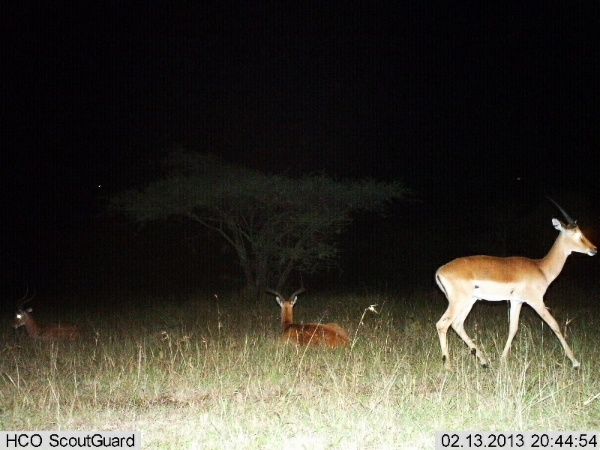

In [32]:
print(species_name)
Image.open(test_image_path)